In [5]:
# Customization
COLORS = {
    "p1": "red", "p2": "blue", "p3": "black",
    "p1_avg": "indianred", "p2_avg": "royalblue", "p3_avg": "gray"
}
IGNORE_PHASE = 600      # Number of initial wins/losses to ignore for winrate calculation
CUTOFF = 100             # Number of last wins to consider for average completion time
LEVELBEATS_PATH = '../logs/levelbeats copy 4.csv'
WINLOSS_PATH = '../logs/winloss copy 2.csv'

In [6]:
import pandas as pd                     # type: ignore
import matplotlib.pyplot as plt         # type: ignore
import matplotlib.gridspec as gridspec  # type: ignore

def convert_to_time(timesteps):
    tps = 80  # estimated value for timesteps per second
    return round(timesteps / tps, 2)

def label_bars(ax, bars, color, append=""):
    for bar in bars:
        yval = bar.get_height()
        ax.text(bar.get_x() + bar.get_width() / 100.0, yval, f'{yval:.2f}{append}', va='bottom', color=color)

def read_winloss_data(path):
    return pd.read_csv(path, header=None, names=['WinLoss', 'Pass'])

def calculate_iterative_winrate(winloss):
    iter_wins, iter_losses = {1: 0, 2: 0, 3: 0}, {1: 0, 2: 0, 3: 0}
    iter_wins_ignore, iter_losses_ignore = {1: 0, 2: 0, 3: 0}, {1: 0, 2: 0, 3: 0}
    iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore = {1: [], 2: [], 3: []}, {1: [], 2: [], 3: []}, [], []
    total_wins, total_losses, total_wins_ignore, total_losses_ignore = 0, 0, 0, 0

    for index, row in winloss.iterrows():
        pass_num = row['Pass']
        if row['WinLoss'] == 'win':
            iter_wins[pass_num] += 1
            if index >= IGNORE_PHASE + (iter_wins[pass_num - 1] if pass_num > 1 else 0) + (iter_losses[pass_num - 2] if pass_num > 2 else 0):
                iter_wins_ignore[pass_num] += 1
                total_wins_ignore += 1
            total_wins += 1
        elif row['WinLoss'] == 'loss':
            iter_losses[pass_num] += 1
            if index >= IGNORE_PHASE + (iter_wins[pass_num - 1] if pass_num > 1 else 0) + (iter_losses[pass_num - 1] if pass_num > 1 else 0) + (iter_wins[pass_num - 2] if pass_num > 2 else 0) + (iter_losses[pass_num - 2] if pass_num > 2 else 0):
                iter_losses_ignore[pass_num] += 1
                total_losses_ignore += 1
            total_losses += 1

        if (iter_wins[pass_num] + iter_losses[pass_num]) > 0:
            iter_winlosses[pass_num].append(iter_wins[pass_num] / (iter_wins[pass_num] + iter_losses[pass_num]) * 100)
        if (iter_wins_ignore[pass_num] + iter_losses_ignore[pass_num]) > 0:
            iter_winlosses_ignore[pass_num].append(iter_wins_ignore[pass_num] / (iter_wins_ignore[pass_num] + iter_losses_ignore[pass_num]) * 100)
        if (total_wins + total_losses) > 0:
            total_winlosses.append(total_wins / (total_wins + total_losses) * 100)
        if (total_wins_ignore + total_losses_ignore) > 0:
            total_winlosses_ignore.append(total_wins_ignore / (total_wins_ignore + total_losses_ignore) * 100)

    return iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore

def plot_winrates(iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore):
    final_winrates = {k: (v[-1] if v else 0) for k, v in iter_winlosses.items()}
    final_ignore_winrates = {k: (v[-1] if v else 0) for k, v in iter_winlosses_ignore.items()}
    final_total_winrate = total_winlosses[-1] if total_winlosses else 0
    final_total_ignore_winrate = total_winlosses_ignore[-1] if total_winlosses_ignore else 0

    plt.figure(figsize=(8.5, 10))
    gs = gridspec.GridSpec(2, 1, width_ratios=[1], height_ratios=[1, 1])
    ax0, ax1 = plt.subplot(gs[0]), plt.subplot(gs[1])

    ax0.set_title('Winrate Progression per Pass during Training (500k timesteps each)')
    ax0.set_xlabel('Iteration (Instance of a Win/Loss)')
    ax0.set_ylabel('Winrate (%)')
    for pass_num in [3, 2, 1]:
        ax0.plot(iter_winlosses[pass_num], color=COLORS[f"p{pass_num}"], label=f'Pass {pass_num} Winrate')
        ax0.axhline(final_ignore_winrates[pass_num], color=COLORS[f"p{pass_num}_avg"], linestyle='dotted', label=f'Pass {pass_num} Winrate ignoring first {IGNORE_PHASE}')
        ax0.annotate(f'{final_winrates[pass_num]:.2f}%', xy=(len(iter_winlosses[pass_num])-1, final_winrates[pass_num]-1), xytext=(1, 0), textcoords='offset points', color=COLORS[f"p{pass_num}"])
        ax0.annotate(f'{final_ignore_winrates[pass_num]:.2f}%', xy=(len(iter_winlosses[pass_num])//4, final_ignore_winrates[pass_num]), xytext=(5, 2), textcoords='offset points', color=COLORS[f"p{pass_num}_avg"], fontsize=10)
    ax0.legend()

    ax1.set_title('Winrate Progression for all passes combined during Training (1.5M timesteps total)')
    ax1.set_xlabel('Iteration (Instance of a Win/Loss)')
    ax1.set_ylabel('Winrate (%)')
    ax1.plot(total_winlosses, color='black', label='Total winrate')
    ax1.annotate(f'{final_total_winrate:.2f}%', xy=(len(total_winlosses)-1, final_total_winrate-0.5), xytext=(1, 0), textcoords='offset points', color='black', fontsize=10)
    ax1.axhline(y=final_total_ignore_winrate, color='gray', linestyle='dotted', label=f'Total Winrate ignoring {IGNORE_PHASE} wins/losses')
    ax1.annotate(f'{final_total_ignore_winrate:.2f}%', xy=(len(total_winlosses)//2, final_total_ignore_winrate), xytext=(5, -10), textcoords='offset points', color='black', fontsize=10)

    for ax in [ax0, ax1]:
        x_left, x_right = ax.get_xlim()
        padding = (x_right - x_left) * 0.1
        ax.set_xlim(x_left, x_right + padding)
        ax.legend()

    plt.show()

def read_levelbeats_data(path):
    levelbeats = pd.read_csv(path, header=None, names=['completion_timesteps', 'training_timesteps', 'time_in_seconds'])

    dropped = 0
    indexes = [index for index, win_time in enumerate(levelbeats['completion_timesteps']) if win_time > 150000]
    for index in indexes:
        levelbeats = levelbeats.drop(index)
        print(f"Outlier dropped at index {index}")
        dropped += 1

    with open(path, 'r') as file:
        lines = file.readlines()
    try:
        split_index1 = lines.index('\n') - dropped
        split_index2 = lines.index('\n', split_index1+1+dropped) - dropped -1
    except:
        split_index1 = len(levelbeats['completion_timesteps'])
        split_index2 = len(levelbeats['completion_timesteps'])

    completion_t = {1: levelbeats['completion_timesteps'][:split_index1], 
                    2: levelbeats['completion_timesteps'][split_index1:split_index2], 
                    3: levelbeats['completion_timesteps'][split_index2:]}
    training_t = {1: levelbeats['training_timesteps'][:split_index1],
                  2: levelbeats['training_timesteps'][split_index1:split_index2],
                  3: levelbeats['training_timesteps'][split_index2:]}
    average_completion_t = {1: convert_to_time(completion_t[1][-CUTOFF:].mean()), 
                            2: convert_to_time(completion_t[2][-CUTOFF:].mean()), 
                            3: convert_to_time(completion_t[3][-CUTOFF:].mean())}
    fastest_completion_t = {1: levelbeats[:split_index1].nsmallest(5, 'completion_timesteps'),
                            2: levelbeats[split_index1:split_index2].nsmallest(5, 'completion_timesteps'),
                            3: levelbeats[split_index2:].nsmallest(5, 'completion_timesteps')}

    return completion_t, training_t, average_completion_t, fastest_completion_t

def plot_levelbeats(completion_t, training_t, average_completion_t, fastest_completion_t):
    fig = plt.figure(figsize=(21, 9))
    gs = gridspec.GridSpec(2, 3, width_ratios=[1, 1, 1.7], height_ratios=[1, 1])
    ax0, ax1, ax2 = plt.subplot(gs[0]), plt.subplot(gs[1]), plt.subplot(gs[2])

    for i in [1, 2, 3]:
        ax0.plot(convert_to_time(completion_t[i]), color=COLORS[f"p{i}"], label=f'Pass {i}')
        ax0.text(150, 750 - 50 * i, f'{len(completion_t[i])} wins for Pass {i} over 500k timesteps', color=COLORS[f"p{i}"], verticalalignment='center', horizontalalignment='left')
        ax1.plot(training_t[i] + 500000 * (i - 1), convert_to_time(completion_t[i]), color=COLORS[f"p{i}"], label=f'Pass {i}')
    ax0.set_title('Level Completion Time & Frequency Improving Over Time')
    ax0.set_ylabel('Time to complete level (seconds)')
    ax0.set_xlabel('Win number (total 1.5M timesteps)')
    ax1.set_title('Level Completion Time vs Training Timesteps')
    ax1.set_xlabel('Training Timesteps (1.5M Total)')
    ax1.set_ylabel('Time to complete level (timesteps)')
    ax1.legend(loc='upper right')

    width = 0.3
    indices = {1: range(len(fastest_completion_t[1]))}
    indices[2] = [index + width for index in indices[1]]
    indices[3] = [index + width for index in indices[2]]

    for i in [1, 2, 3]:
        bars = ax2.bar(indices[i], convert_to_time(fastest_completion_t[i]['completion_timesteps']), width=width, label=f'Pass {i}', color=COLORS[f"p{i}"])
        label_bars(ax2, bars, COLORS[f"p{i}"])
    bars1_avg = ax2.bar([max(indices[2]) + 1], [average_completion_t[1]], width=width, label='Average Pass 2', color=COLORS[f"p1_avg"])
    bars2_avg = ax2.bar([max(indices[2]) + 1 + width], [average_completion_t[2]], width=width, label='Average Pass 2', color=COLORS[f"p2_avg"])
    bars3_avg = ax2.bar([max(indices[3]) + 1 + width], [average_completion_t[3]], width=width, label='Average Pass 3', color=COLORS[f"p3_avg"])
    label_bars(ax2, bars1_avg, COLORS[f"p1"])
    label_bars(ax2, bars2_avg, COLORS[f"p2"])
    label_bars(ax2, bars3_avg, COLORS[f"p3"])

    ax2.set_xticks(list(indices[2]) + [max(indices[3]) + 1])
    ax2.set_xticklabels(list(range(1, len(fastest_completion_t[1]) + 1)) + [f'Average (Last {CUTOFF})'])
    ax2.set_title('Fastest Win Times with Multipass Method, after 1.5M timesteps')
    ax2.set_ylabel('Time to win (seconds)')
    ax2.set_xlabel('Place')
    ax2.legend()

    plt.tight_layout(rect=[0, 0, 1, 1])
    plt.show()

In [7]:
def plot_specific(winloss_paths, levelbeats_paths):
    data = {}
    
    # Process win/loss and level beats data for each pass
    for p in winloss_paths.keys():
        winloss = read_winloss_data(winloss_paths[p])
        iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore = calculate_iterative_winrate(winloss)
        completion_t, training_t, average_completion_t, fastest_completion_t = read_levelbeats_data(levelbeats_paths[p])
        
        data[p] = {
            "iter_winlosses": iter_winlosses,
            "iter_winlosses_ignore": iter_winlosses_ignore,
            "total_winlosses": total_winlosses,
            "total_winlosses_ignore": total_winlosses_ignore,
            "completion_t": completion_t,
            "training_t": training_t,
            "average_completion_t": average_completion_t,
            "fastest_completion_t": fastest_completion_t
        }
    
    fig = plt.figure(figsize=(12, 5))
    gs = gridspec.GridSpec(1, 2, width_ratios=[1, 1], height_ratios=[1])
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1])

    # Plot Winrate Progression
    ax0.set_title('Winrate Progression during Training')
    ax0.set_xlabel('Iteration (Instance of a Win/Loss)')
    ax0.set_ylabel('Winrate (%)')
    
    for p, color in zip(data.keys(), ['red', 'blue', 'black']):
        iter_winlosses = data[p]['iter_winlosses']
        final_ignore_winrates = {k: (v[-1] if v else 0) for k, v in iter_winlosses.items()}
        for pass_num in iter_winlosses.keys():
            ax0.plot(iter_winlosses[pass_num], color=COLORS[f"p{pass_num}"], label=f'Pass {pass_num} Winrate')
            ax0.axhline(final_ignore_winrates[pass_num], color=COLORS[f"p{pass_num}_avg"], linestyle='dotted', label=f'Pass {pass_num} Winrate ignoring first {IGNORE_PHASE}')
            ax0.annotate(f'{final_ignore_winrates[pass_num]:.2f}%', xy=(len(iter_winlosses[pass_num])-1, final_ignore_winrates[pass_num]-1), xytext=(1, 0), textcoords='offset points', color=COLORS[f"p{pass_num}"])
    ax0.legend()
    
    # Plot Level Completion Time vs Training Timesteps
    ax1.set_title('Level Completion Time vs Training Timesteps')
    ax1.set_xlabel('Training Timesteps')
    ax1.set_ylabel('Time to complete level (seconds)')
    
    for p in data.keys():
        completion_t = data[p]['completion_t']
        training_t = data[p]['training_t']
        average_completion_t = data[p]['average_completion_t']
        fastest_completion_t = data[p]['fastest_completion_t']
        
        for i in completion_t.keys():
            ax1.plot(training_t[i], convert_to_time(completion_t[i]), color=COLORS[f"p{i}"], label=f'Pass {i}')
        ax1.plot(training_t[i], [average_completion_t[i]] * len(training_t[i]), color=COLORS[f"p{i}_avg"], linestyle='dotted', label=f'Average Pass {i}')
    
    ax1.legend()
    plt.tight_layout()
    plt.show()


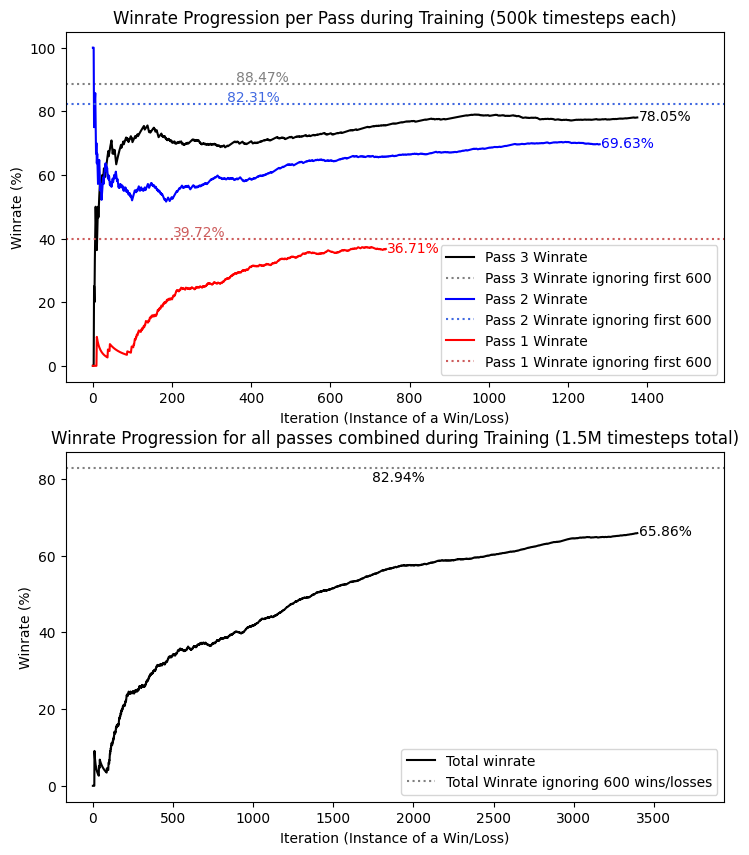

Outlier dropped at index 3
Outlier dropped at index 5
Outlier dropped at index 6
Outlier dropped at index 8
Outlier dropped at index 12


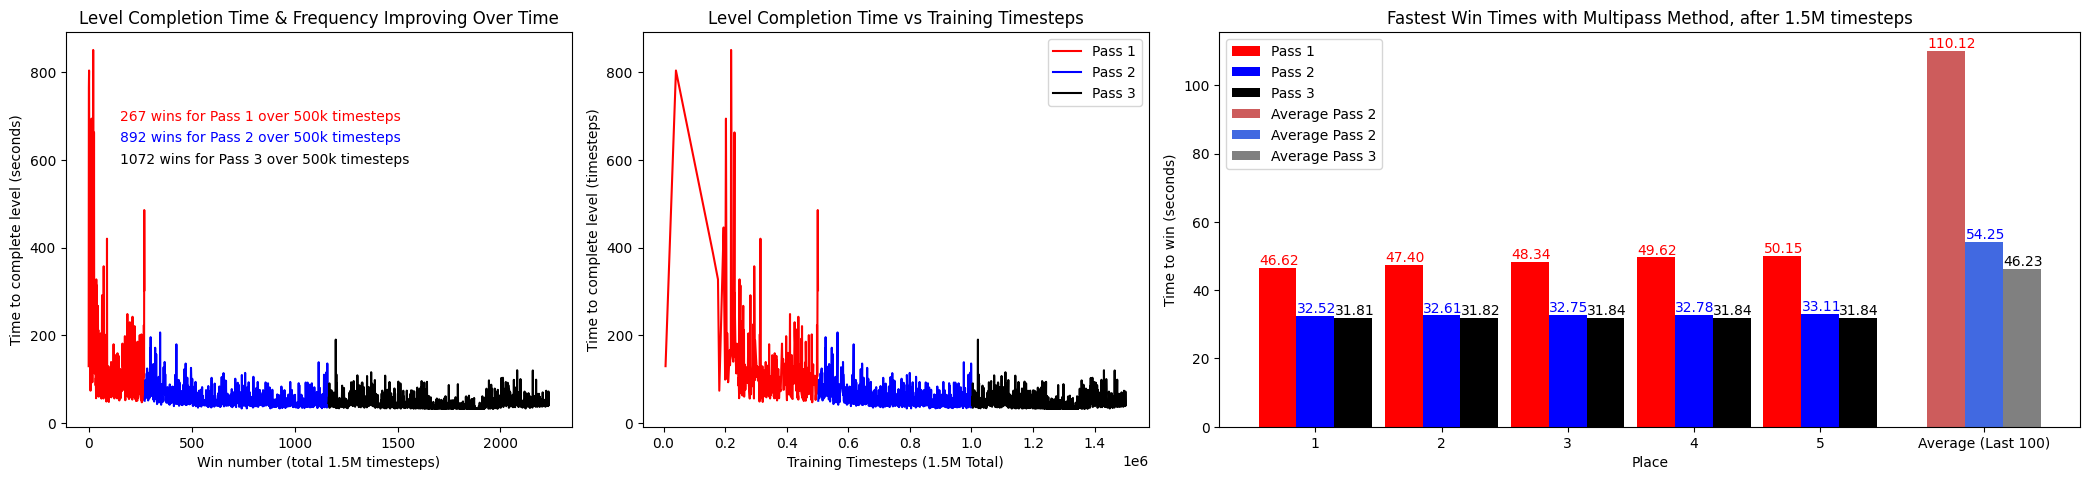

FileNotFoundError: [Errno 2] No such file or directory: './logs/winloss pass1only.csv'

In [8]:
def main():
    winloss = read_winloss_data(WINLOSS_PATH)
    iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore = calculate_iterative_winrate(winloss)
    plot_winrates(iter_winlosses, iter_winlosses_ignore, total_winlosses, total_winlosses_ignore)
    completion_t, training_t, average_completion_t, fastest_completion_t = read_levelbeats_data(LEVELBEATS_PATH)
    plot_levelbeats(completion_t, training_t, average_completion_t, fastest_completion_t)

    plot_specific(
        winloss_paths = {1: './logs/winloss pass1only.csv', 3: './logs/winloss pass3only.csv'},
        levelbeats_paths = {1: './logs/levelbeats pass1only.csv', 3: './logs/levelbeats pass3only.csv'}
    )
if __name__ == "__main__":
    main()